<a href="https://colab.research.google.com/github/kristacourtaway/Austin-Housing/blob/main/Austin_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries and Data

In [ ]:
install.packages('caret')
install.packages('tidytext')
install.packages('syuzhet')
install.packages('randomForest')
install.packages('sf')
install.packages('forecast')

In [12]:
library(tidyverse)
library(caret)
library(tidytext)
library(syuzhet)
library(randomForest)
library(sf)
library(ggplot2)
library(dplyr)
library(lubridate)
library(forecast)
library(readr)

In [13]:
data <- read.csv("/content/austinHousingData.csv")

In [14]:
head(data)

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,⋯,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,⋯,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<chr>
1,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 is a single family home that contains 2,601 sq ft and was built in 2012. It contains 4 bedrooms and 3 bathrooms. The Zestimate for this house is $344,417. The Rent Zestimate for this home is $2,195/mo.",30.43063,-97.66308,1.98,2,TRUE,⋯,1,1,1.266667,2.666667,1063,14,3,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f.jpg
2,120900430,pflugerville,1104 Strickling Dr,78660,"Absolutely GORGEOUS 4 Bedroom home with 2 full baths located in the tucked away Pflugerville community The Lakes at Northtown. This home was recently updated with new carpets, new tile kitchen back splash, and fresh paint throughout the entire house. This charming abode is a MUST SEE if you're looking for an affordable home in the Austin area. Something very hard to come by in this market! Only 14 miles from downtown, this home will accommodate downtown commuting as well as a work from home environment. This community is tucked away and yet only minutes from major retailers and shopping. Do not miss this opportunity!",30.43267,-97.66170,1.98,2,TRUE,⋯,1,1,1.400000,2.666667,1063,14,2,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f.jpg
3,2084491383,pflugerville,1408 Fort Dessau Rd,78660,"Under construction - estimated completion in August 2019. The Pioneer features an expansive open floorplan, 3 spacious bedrooms, 2 bathrooms, and a stunning kitchen. Upon entering the Pioneer, you will pass through the impressive entry way. Keep walking, and you will pass the two private secondary bedrooms which both have large walk-in closets. The entryway leads you into the huge open family room and kitchen area with a huge island with granite counters. Next to the kitchen is the dining room, conveniently separated from the main living area of the family room. A large covered patio greets you as you walk out the back door into the backyard. A private and spacious master suite is the cherry on top of this home and will provide a quiet place for you to relax after a long day. This home is very close to the fantastic amenity center. All of this in just 1472 sqft is a deal that you will find very hard to beat!",30.40975,-97.63977,1.98,0,TRUE,⋯,1,1,1.200000,3.000000,1108,14,2,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_f.jpg
4,120901374,pflugerville,1025 Strickling Dr,78660,"Absolutely darling one story home in charming story book like The Lakes of Northtown! Built in 2013, this home has hardly been lived in and is just like new. It is perfect for someone looking for low maintenance living that is close to movies, shopping, groceries, and has quick access to the highways!",30.43211,-97.66166,1.98,2,TRUE,⋯,1,1,1.400000,2.666667,1063,14,2,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f.jpg
5,60134862,pflugerville,15005 Donna Jane Loop,78660,"Brimming with appeal & warm livability! Sleek & stylish home with modern finishes & amenities await you! Enjoy the open floor plan, gorgeous gourmet kitchen with center island, spacious living room, high ceiling, stay cozy by the fireplace in family room and so much more! Backyard - perfect for outdoor fun! This won't last!",30.43737,-97.65686,1.98,0,TRUE,⋯,1,1,1.133333,4.000000,1223,14,3,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg
6,2080105342,pflugerville,14908 Spring Hill Ln,78660,"14908 Spring Hill Ln, Pflugerville, TX 78660 is a single family home that contains 1,446 sq ft and was built in 2020. It contains 3 bedrooms and 2 bathrooms. The Zestimate for this house is $307,210.",30.43777,-97.65618,1.98,2,TRUE,⋯,1,1,1.066667,4.000000,1223,14

In [15]:
handle_missing_values <- function(data) {
  data[is.na(data)] <- 0
  return(data)
}

In [16]:
train_test_split <- function(data, target_column, split_ratio = 0.8) {
  set.seed(123)
  splitIndex <- createDataPartition(data[[target_column]], p = split_ratio, list = FALSE, times = 1)
  train_data <- data[splitIndex,]
  test_data <- data[-splitIndex,]
  return(list(train_data, test_data))
}

## Descriptive Analytics

In [17]:
selected_features <- data[, c("numOfBathrooms", "numOfBedrooms", "livingAreaSqFt")]


In [18]:
summary_stats <- selected_features %>%
  summarise(
    mean_numOfBathrooms = mean(numOfBathrooms, na.rm = TRUE),
    median_numOfBathrooms = median(numOfBathrooms, na.rm = TRUE),
    sd_numOfBathrooms = sd(numOfBathrooms, na.rm = TRUE),
    min_numOfBathrooms = min(numOfBathrooms, na.rm = TRUE),
    max_numOfBathrooms = max(numOfBathrooms, na.rm = TRUE),
    mean_numOfBedrooms = mean(numOfBedrooms, na.rm = TRUE),
    median_numOfBedrooms = median(numOfBedrooms, na.rm = TRUE),
    sd_numOfBedrooms = sd(numOfBedrooms, na.rm = TRUE),
    min_numOfBedrooms = min(numOfBedrooms, na.rm = TRUE),
    max_numOfBedrooms = max(numOfBedrooms, na.rm = TRUE),
    mean_livingAreaSqFt = mean(livingAreaSqFt, na.rm = TRUE),
    median_livingAreaSqFt = median(livingAreaSqFt, na.rm = TRUE),
    sd_livingAreaSqFt = sd(livingAreaSqFt, na.rm = TRUE),
    min_livingAreaSqFt = min(livingAreaSqFt, na.rm = TRUE),
    max_livingAreaSqFt = max(livingAreaSqFt, na.rm = TRUE)
  )

In [19]:
print(summary_stats)

  mean_numOfBathrooms median_numOfBathrooms sd_numOfBathrooms
1             2.68301                     3          1.054445
  min_numOfBathrooms max_numOfBathrooms mean_numOfBedrooms median_numOfBedrooms
1                  0                 27            3.44038                    3
  sd_numOfBedrooms min_numOfBedrooms max_numOfBedrooms mean_livingAreaSqFt
1        0.8499418                 0                20            2208.323
  median_livingAreaSqFt sd_livingAreaSqFt min_livingAreaSqFt max_livingAreaSqFt
1                  1975          1378.576                300             109292


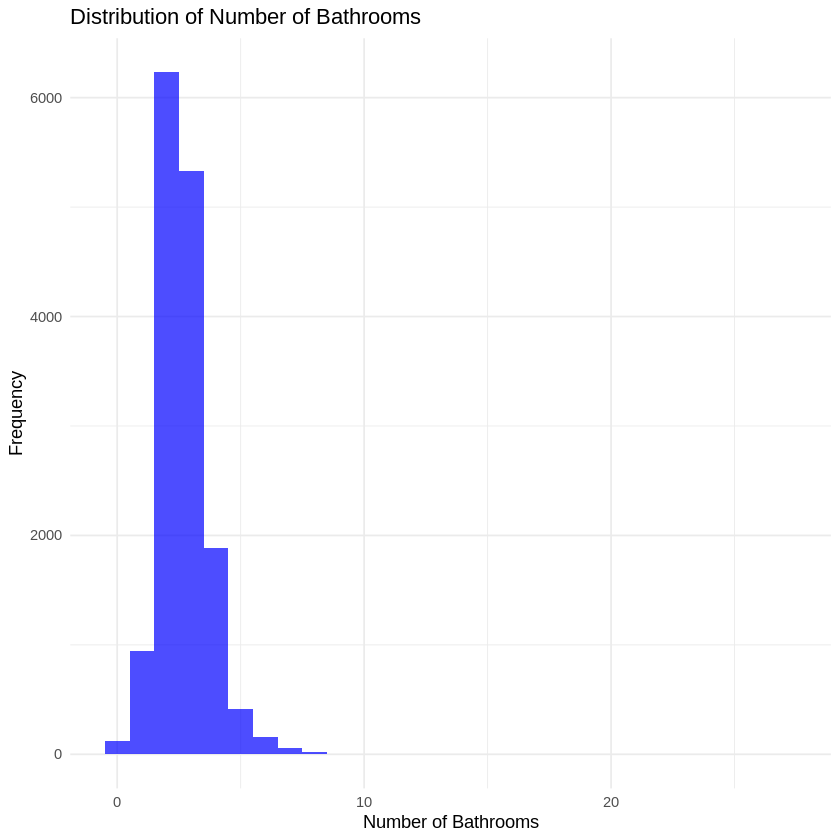

In [20]:
# Create histograms for various features
# For Number of Bathrooms
ggplot(selected_features, aes(x = numOfBathrooms)) +
  geom_histogram(binwidth = 1, fill = "blue", alpha = 0.7) +
  labs(title = "Distribution of Number of Bathrooms", x = "Number of Bathrooms", y = "Frequency") +
  theme_minimal()

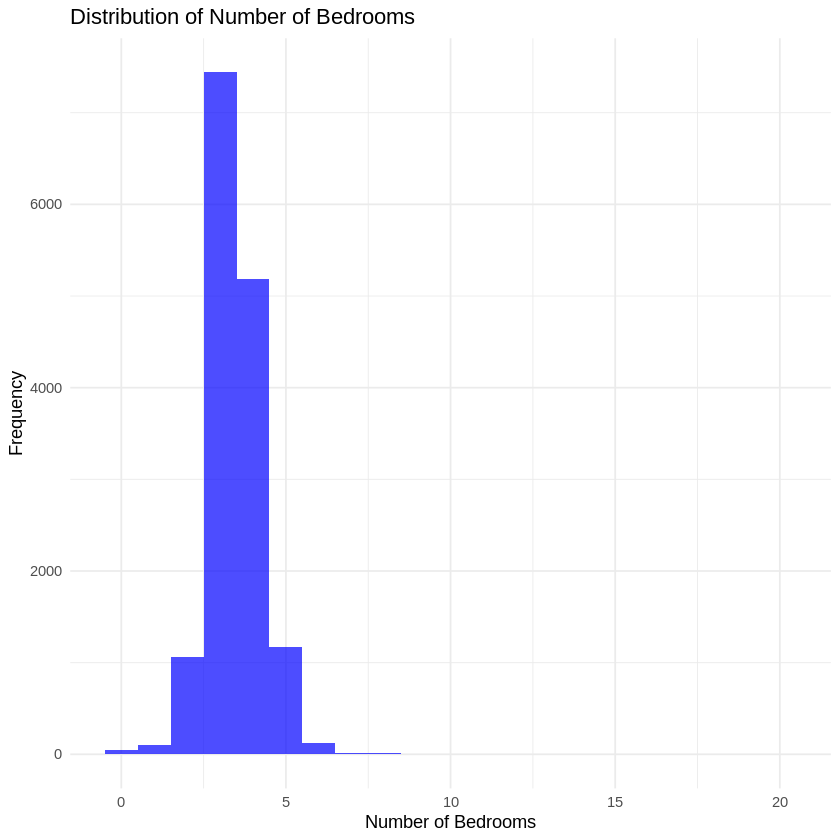

In [21]:
# For Number of Bedrooms
ggplot(selected_features, aes(x = numOfBedrooms)) +
  geom_histogram(binwidth = 1, fill = "blue", alpha = 0.7) +
  labs(title = "Distribution of Number of Bedrooms", x = "Number of Bedrooms", y = "Frequency") +
  theme_minimal()

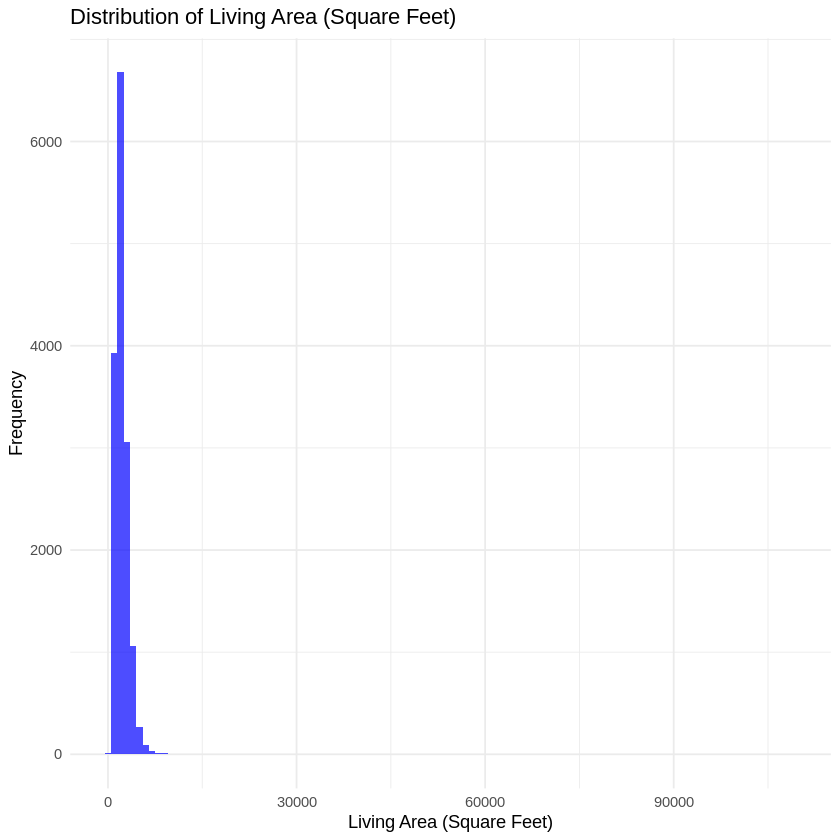

In [22]:
# For Living Area in Square Feet
ggplot(selected_features, aes(x = livingAreaSqFt)) +
  geom_histogram(binwidth = 1000, fill = "blue", alpha = 0.7) +
  labs(title = "Distribution of Living Area (Square Feet)", x = "Living Area (Square Feet)", y = "Frequency") +
  theme_minimal()

In [23]:
# Assess the relationship between hasGarage and parkingSpaces
correlation_garage_parking <- cor(data$hasGarage, data$parkingSpaces, method = "spearman", use = "complete.obs")
print(paste("Correlation between hasGarage and parkingSpaces:", correlation_garage_parking))

[1] "Correlation between hasGarage and parkingSpaces: 0.92527613887694"


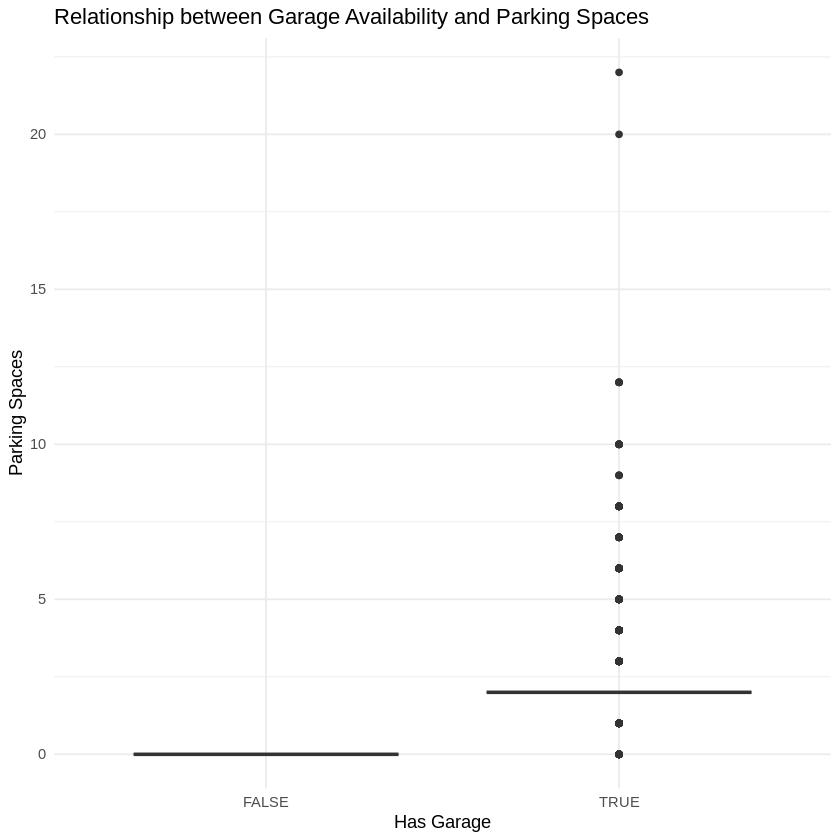

In [24]:
# Plotting hasGarage vs parkingSpaces
ggplot(data, aes(x = as.factor(hasGarage), y = parkingSpaces)) +
  geom_boxplot() +
  labs(title = "Relationship between Garage Availability and Parking Spaces",
       x = "Has Garage",
       y = "Parking Spaces") +
  theme_minimal()

In [25]:
# Assess the relationship between hasCooling and hasHeating using a contingency table
contingency_table_cooling_heating <- table(data$hasCooling, data$hasHeating)
print("Contingency table between hasCooling and hasHeating:")
print(contingency_table_cooling_heating)

[1] "Contingency table between hasCooling and hasHeating:"
       
        FALSE  TRUE
  FALSE   138   136
  TRUE     11 14886


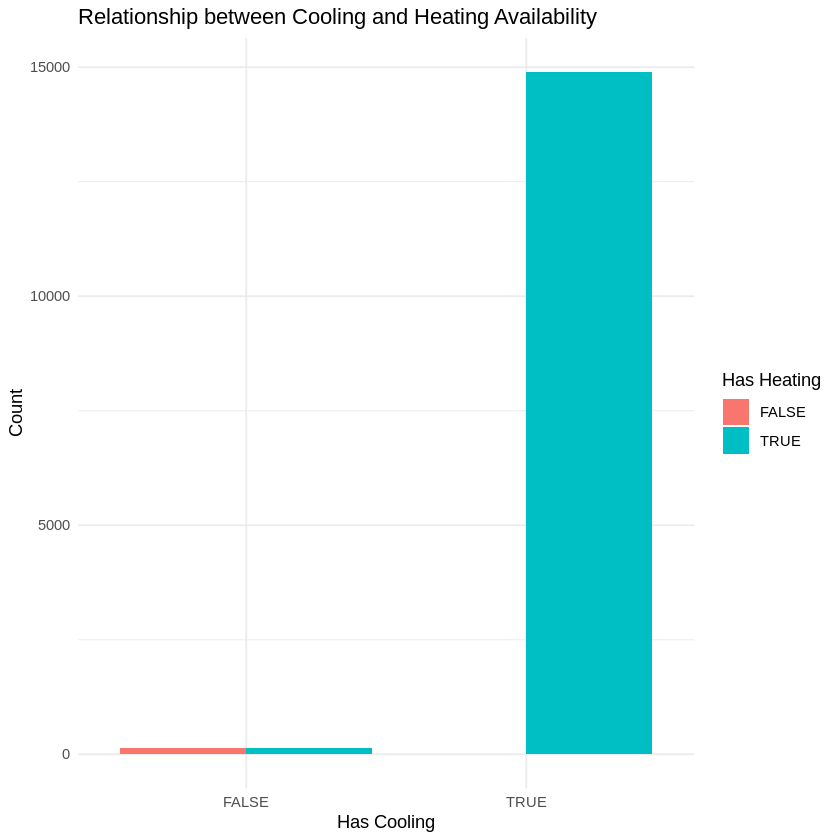

In [26]:
# Plotting hasCooling vs hasHeating
ggplot(data, aes(x = as.factor(hasCooling), fill = as.factor(hasHeating))) +
  geom_bar(position = "dodge") +
  labs(title = "Relationship between Cooling and Heating Availability",
       x = "Has Cooling",
       y = "Count",
       fill = "Has Heating") +
  theme_minimal()

## School Analysis

In [27]:
school_data <- data[, c('avgSchoolDistance', 'avgSchoolRating', 'avgSchoolSize', 'latestPrice')]

In [28]:
school_data <- handle_missing_values(school_data)

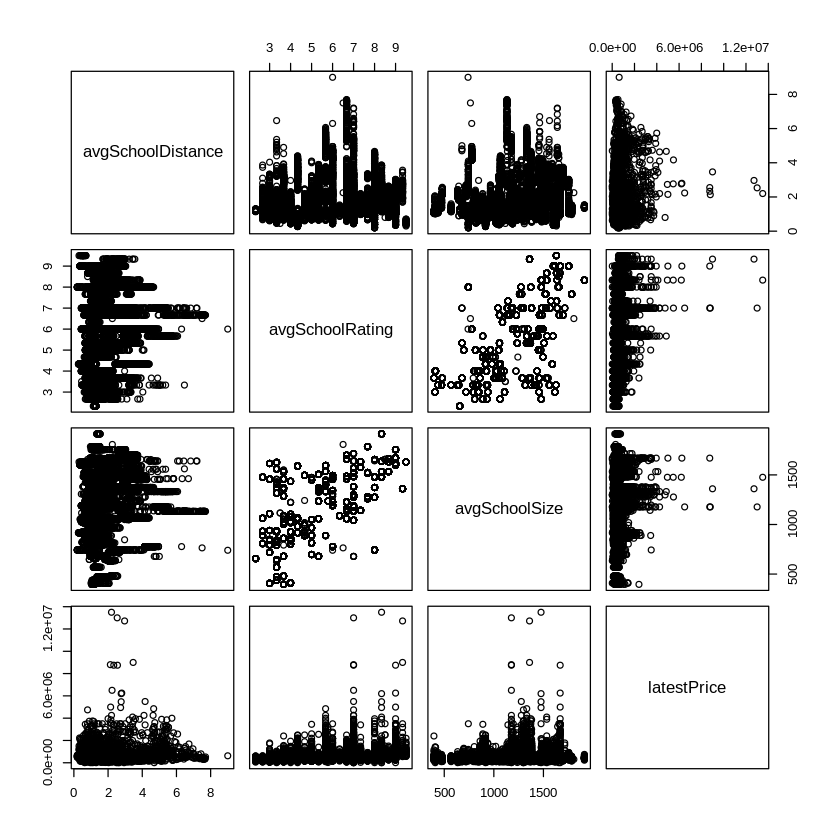

In [29]:
pairs(school_data)

In [30]:
model <- lm(latestPrice ~ avgSchoolDistance + avgSchoolRating + avgSchoolSize, data = school_data)


In [31]:
summary(model)


Call:
lm(formula = latestPrice ~ avgSchoolDistance + avgSchoolRating + 
    avgSchoolSize, data = school_data)

Residuals:
     Min       1Q   Median       3Q      Max 
 -732914  -181667   -75516    51345 12791352 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       196716.18   14559.71  13.511   <2e-16 ***
avgSchoolDistance  29813.13    3303.59   9.024   <2e-16 ***
avgSchoolRating    93650.37    2377.59  39.389   <2e-16 ***
avgSchoolSize       -226.34      13.61 -16.632   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 428700 on 15167 degrees of freedom
Multiple R-squared:  0.1054,	Adjusted R-squared:  0.1052 
F-statistic: 595.7 on 3 and 15167 DF,  p-value: < 2.2e-16


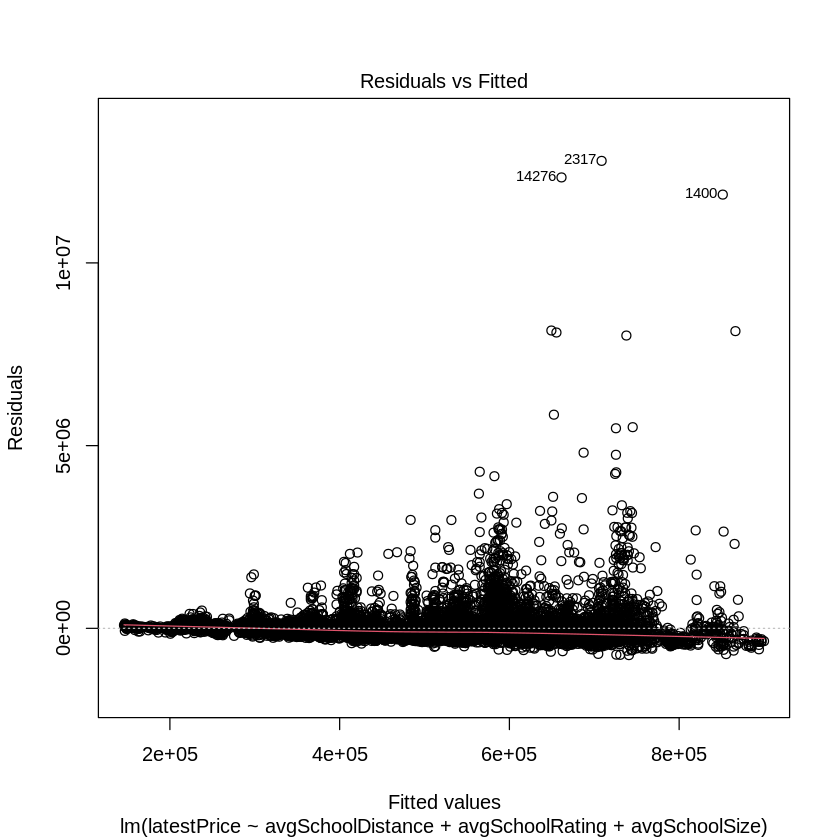

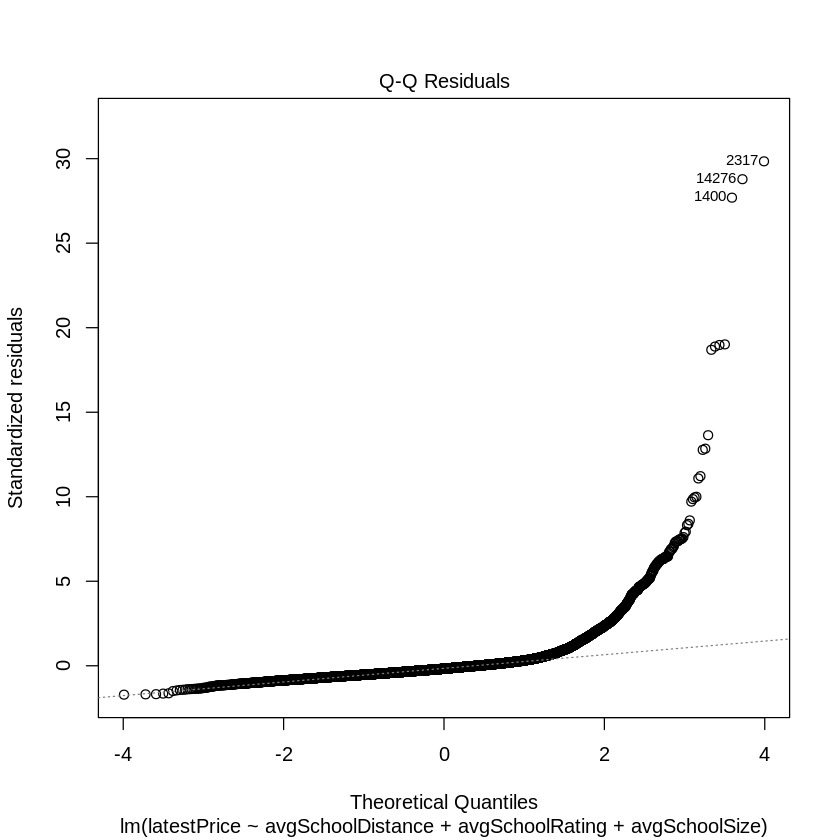

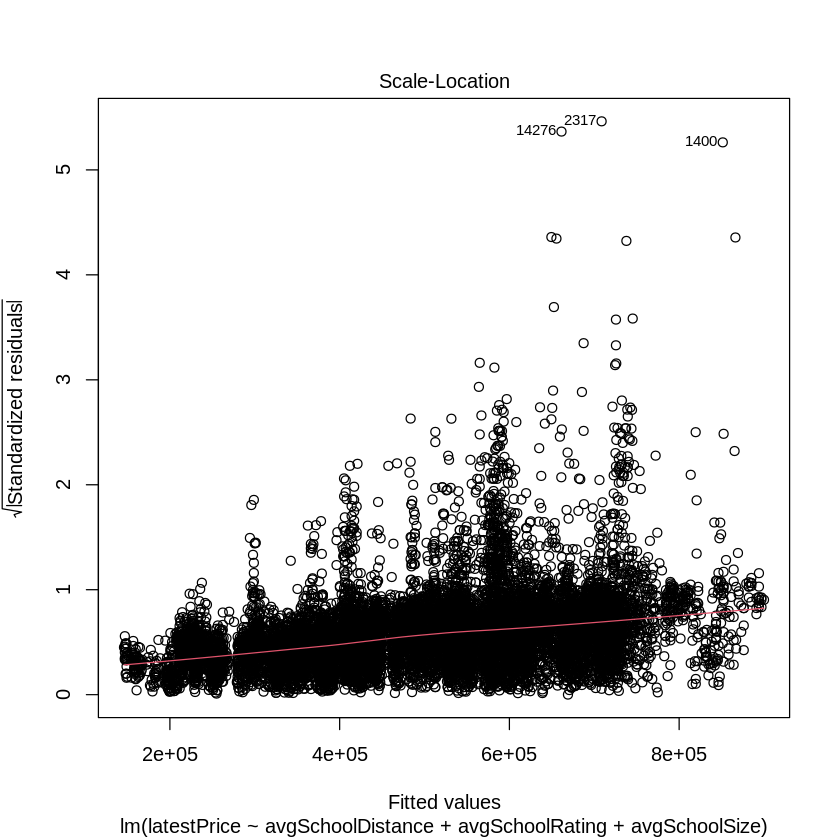

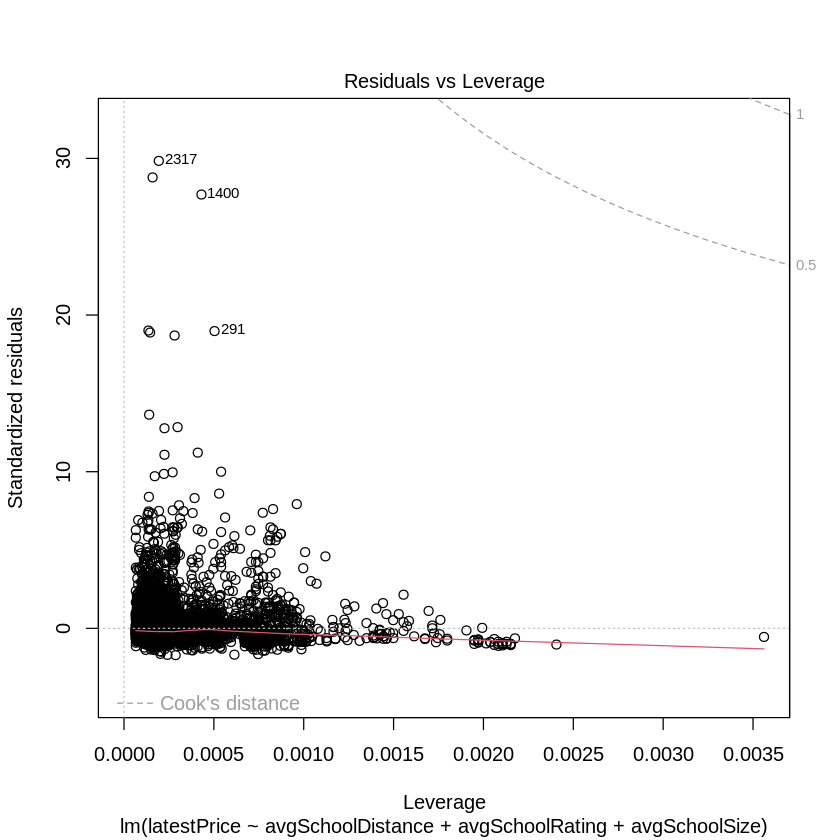

In [32]:
plot(model)

## Time Series Analysis

In [33]:
# Convert latest_saledate, latest_salemonth, latest_saleyear into a proper date format
data$latest_saledate <- as.Date(paste(data$latest_saleyear, data$latest_salemonth, data$latest_saledate, sep = "-"))

In [34]:
# Aggregate latestPrice by date
time_series_data <- data %>%
  group_by(latest_saledate) %>%
  summarise(price = mean(latestPrice, na.rm = TRUE)) %>%
  arrange(latest_saledate)

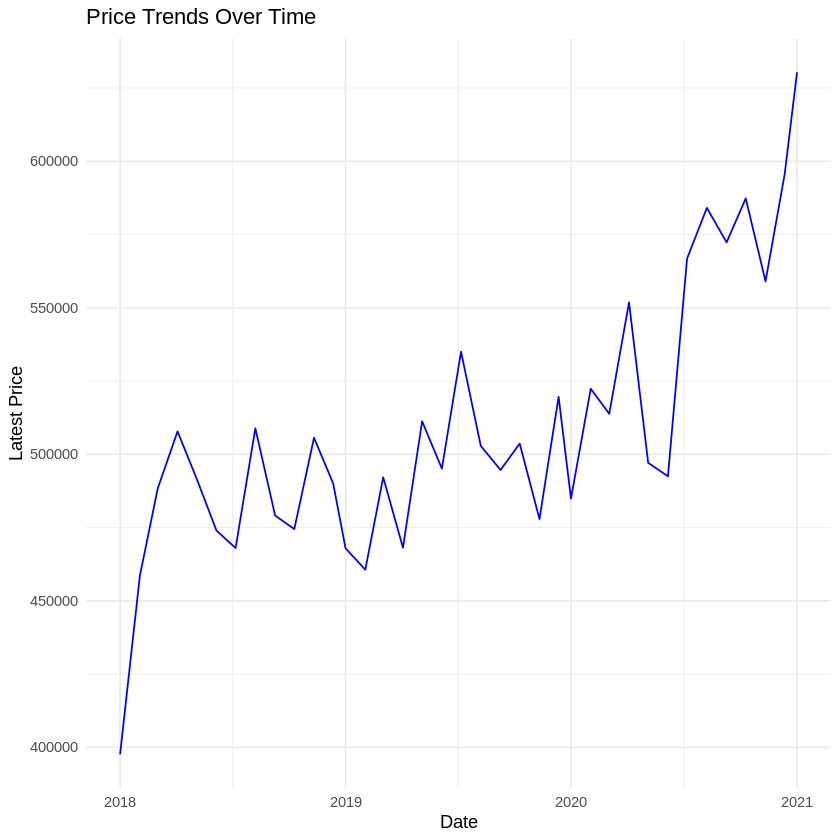

In [35]:
# Plot the time series
ggplot(time_series_data, aes(x = latest_saledate, y = price)) +
  geom_line(color = "blue") +
  labs(title = "Price Trends Over Time",
       x = "Date",
       y = "Latest Price") +
  theme_minimal()

In [36]:
# Fit an ARIMA model
model <- auto.arima(time_series_data$price)

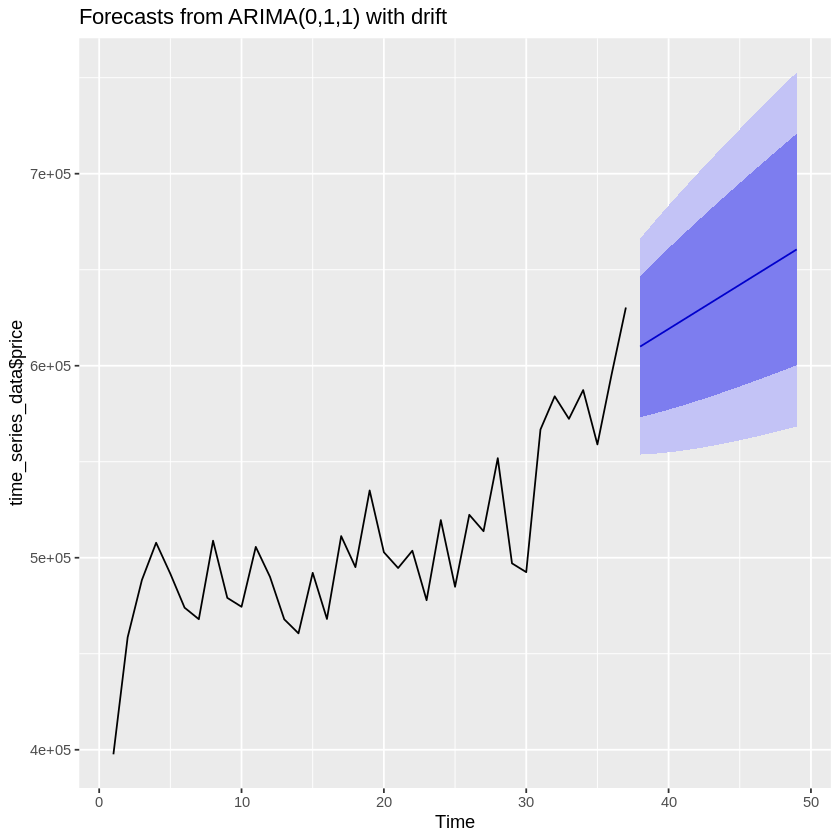

In [37]:
# Forecast the next 12 months
forecast_result <- forecast(model, h = 12)
autoplot(forecast_result)

In [38]:
# Create a spatial points data frame
coordinates <- data.frame(longitude = data$longitude, latitude = data$latitude)
coordinates_sf <- st_as_sf(coordinates, coords = c("longitude", "latitude"), crs = 4326)

In [39]:
coordinates_sf <- handle_missing_values(coordinates_sf)

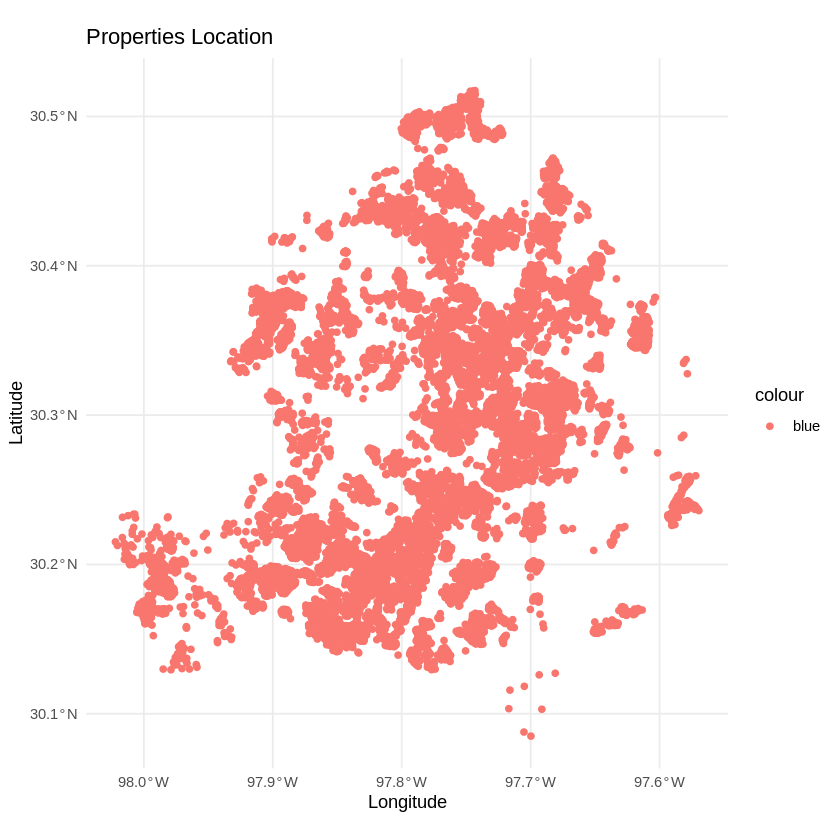

In [40]:
# Plot the properties using ggplot
ggplot(data = coordinates_sf) +
  geom_sf(aes(color = "blue")) +
  labs(title = "Properties Location",
       x = "Longitude",
       y = "Latitude") +
  theme_minimal()

## Geospatial Analysis

In [41]:
# Create a spatial points data frame
coordinates <- data.frame(longitude = data$longitude, latitude = data$latitude)
coordinates_sf <- st_as_sf(coordinates, coords = c("longitude", "latitude"), crs = 4326)

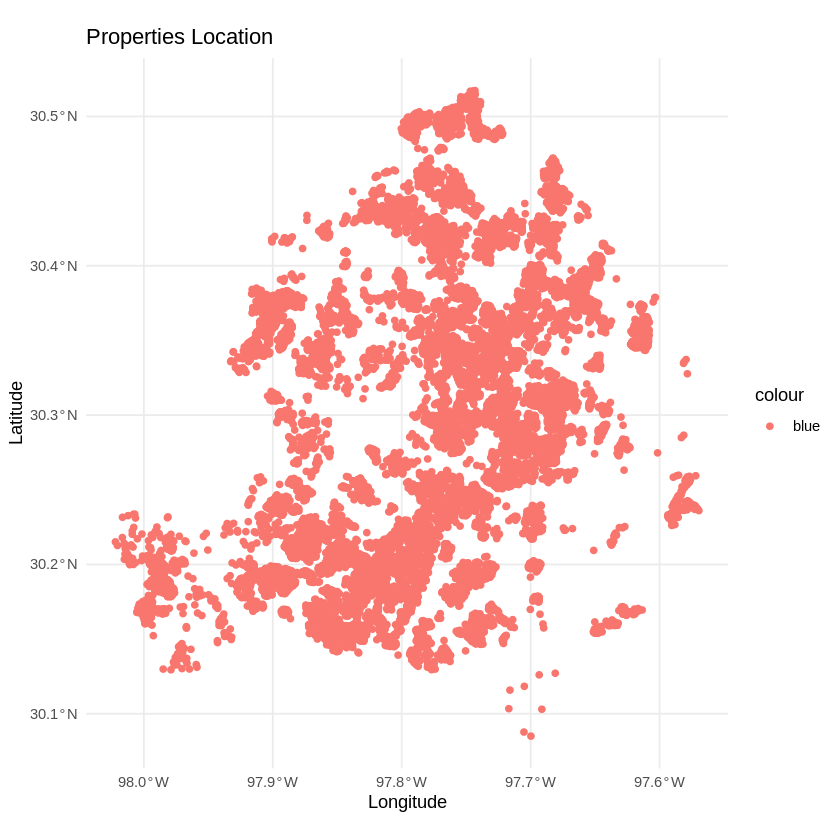

In [42]:
# Plot the properties using ggplot
ggplot(data = coordinates_sf) +
  geom_sf(aes(color = "blue")) +
  labs(title = "Properties Location",
       x = "Longitude",
       y = "Latitude") +
  theme_minimal()

## Text Analysis

In [43]:
# Preprocess the data
data$description <- tolower(data$description)
data$description <- gsub("[^a-z\\s]", "", data$description)

In [44]:
data$description <- handle_missing_values(data$description)


In [45]:
# Extract sentiment using the syuzhet method
sentiment_scores <- get_sentiment(data$description, method="syuzhet")

In [46]:
# Categorize sentiment scores
data$sentiment_category <- ifelse(sentiment_scores > 0, "Positive",
                                  ifelse(sentiment_scores < 0, "Negative", "Neutral"))

In [47]:
# Summary of sentiment scores
summary_sentiment <- summary(sentiment_scores)
print("Summary of Sentiment Scores:")
print(summary_sentiment)

[1] "Summary of Sentiment Scores:"
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.00e+00 0.00e+00 0.00e+00 8.57e-05 0.00e+00 8.00e-01 


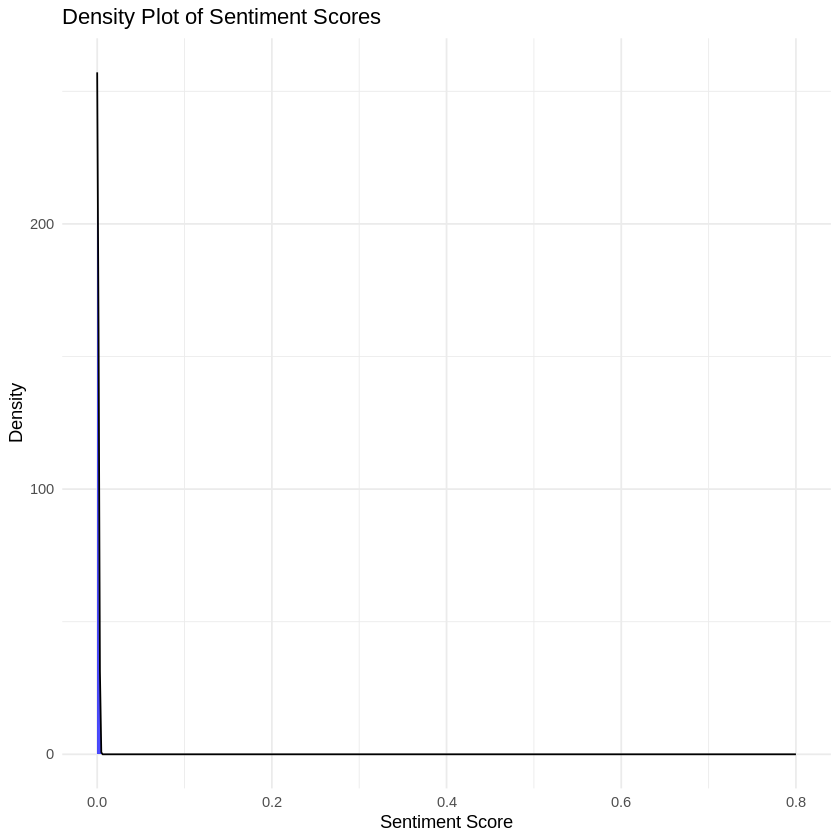

In [48]:
# Density plot of sentiment scores
ggplot(data, aes(x = sentiment_scores)) +
  geom_density(fill = "blue", alpha = 0.7) +
  labs(title = "Density Plot of Sentiment Scores",
       x = "Sentiment Score",
       y = "Density") +
 theme_minimal()


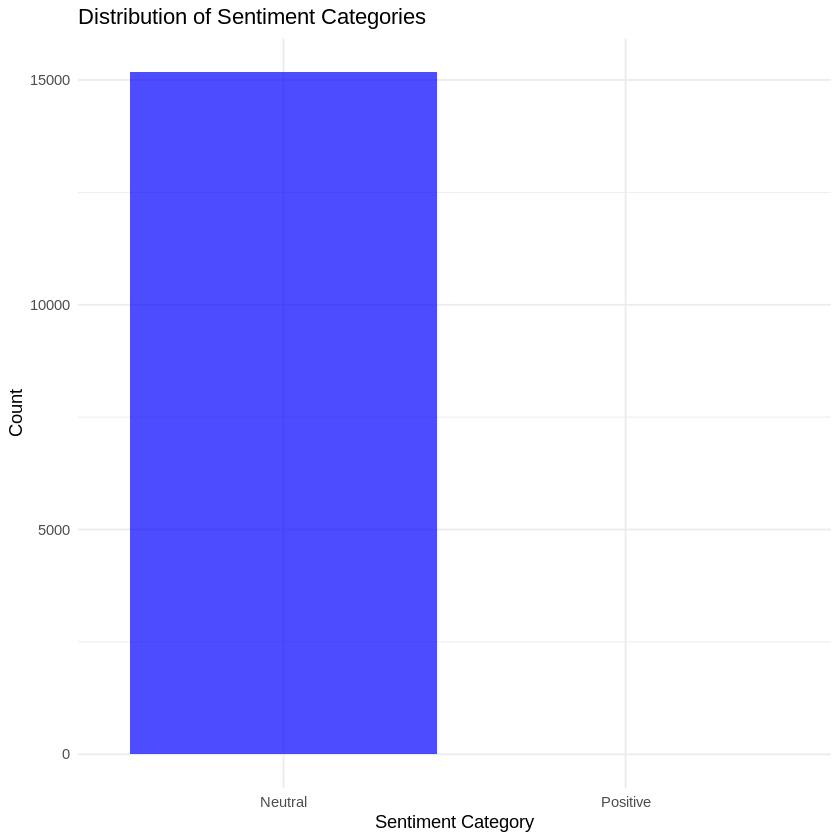

In [49]:
# Bar plot of sentiment categories
ggplot(data, aes(x = sentiment_category)) +
  geom_bar(fill = "blue", alpha = 0.7) +
  labs(title = "Distribution of Sentiment Categories",
       x = "Sentiment Category",
       y = "Count") +
  theme_minimal()

## Predictive Modeling

In [50]:
features <- c("zipcode", "latitude", "longitude", "propertyTaxRate", "garageSpaces", "yearBuilt", "latestPrice")
data_selected <- data[, features]

In [51]:
data_selected <- handle_missing_values(data_selected)

In [52]:
# Split data into training and testing sets
train_test_data <- train_test_split(data_selected, 'latestPrice')
train_data <- train_test_data[[1]]
test_data <- train_test_data[[2]]

In [53]:
# Build a linear regression model
model <- lm(latestPrice ~ ., data = train_data)

In [54]:
# Make predictions on the test set
predictions <- predict(model, test_data)

In [55]:
# Evaluate the model using RMSE
rmse <- sqrt(mean((predictions - test_data$latestPrice)^2))
print(paste("Root Mean Squared Error (RMSE):", rmse))

[1] "Root Mean Squared Error (RMSE): 366246.36691777"


In [56]:
features_classification <- c("livingAreaSqFt", "numOfBathrooms", "numOfBedrooms", "homeType")
data_selected_classification <- data[, features_classification]

In [57]:
# Handle missing values
data_selected_classification <- handle_missing_values(data_selected_classification)

In [58]:
# Convert homeType to a factor
data_selected_classification$homeType <- as.factor(data_selected_classification$homeType)

In [59]:
# Split data into training and testing sets
train_test_data_classification <- train_test_split(data_selected_classification, 'homeType')
train_data_classification <- train_test_data_classification[[1]]
test_data_classification <- train_test_data_classification[[2]]

In [60]:
# Build a Random Forest model
model_classification <- randomForest(homeType ~ ., data = train_data_classification)

In [61]:
# Make predictions on the test set
predictions_classification <- predict(model_classification, test_data_classification)

In [62]:
# Evaluate the model using accuracy
accuracy <- sum(predictions_classification == test_data_classification$homeType) / nrow(test_data_classification)
print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.942923127680633"
